In [1]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
api_key = '36N2WM8I8W74IFZ0'

In [3]:
ts = TimeSeries(key=api_key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='TSLA', interval = '60min', outputsize = 'full')
print(data)

                     1. open  2. high  3. low  4. close  5. volume
date                                                              
2021-04-26 20:00:00   718.60   722.02  718.60   719.860   183201.0
2021-04-26 19:00:00   725.88   738.20  718.50   718.523   332418.0
2021-04-26 18:00:00   722.85   738.20  720.12   725.880   600940.0
2021-04-26 17:00:00   738.20   745.00  715.17   723.450  2803917.0
2021-04-26 16:00:00   736.73   740.59  733.48   738.000  4853340.0
...                      ...      ...     ...       ...        ...
2021-03-01 09:00:00   691.50   691.60  686.32   689.000   164620.0
2021-03-01 08:00:00   693.28   693.28  686.32   689.000   164240.0
2021-03-01 07:00:00   693.83   695.50  689.85   693.720    26319.0
2021-03-01 06:00:00   695.00   697.96  693.55   693.550    28177.0
2021-03-01 05:00:00   692.51   700.00  692.01   693.790    66780.0

[640 rows x 5 columns]


In [4]:
close_data = data['4. close']
print (close_data)

date
2021-04-15 20:00:00    738.25
2021-04-15 19:59:00    738.34
2021-04-15 19:58:00    738.34
2021-04-15 19:57:00    738.30
2021-04-15 19:56:00    738.20
                        ...  
2021-04-05 04:05:00    693.57
2021-04-05 04:04:00    697.11
2021-04-05 04:03:00    700.54
2021-04-05 04:02:00    700.03
2021-04-05 04:01:00    700.05
Name: 4. close, Length: 6732, dtype: float64


<AxesSubplot:xlabel='date'>

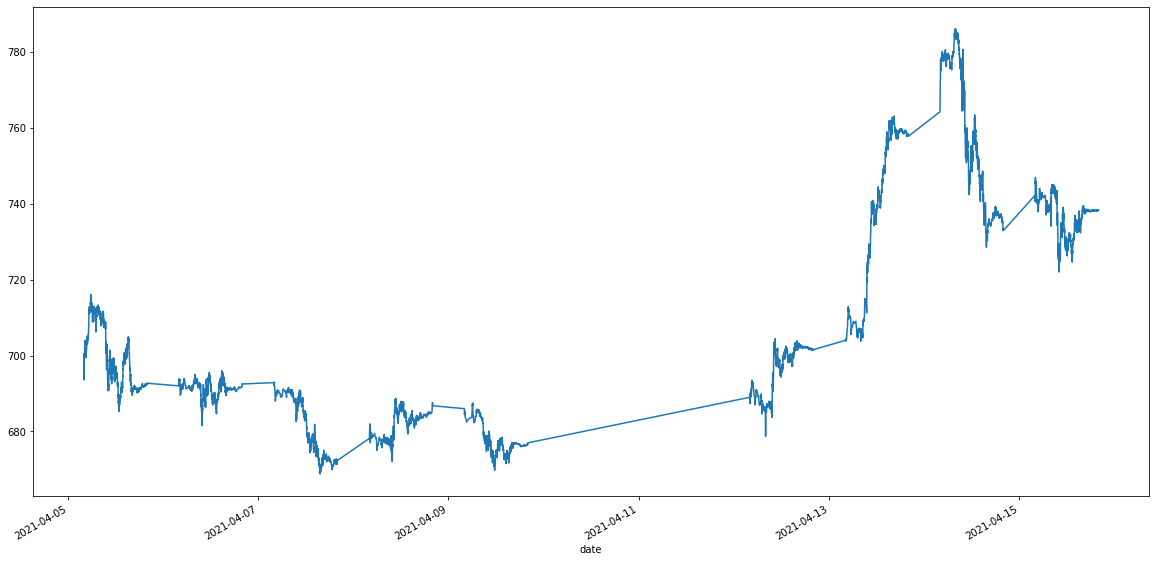

In [5]:
close_data.plot(figsize=(20,10))

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))

In [7]:
prediction_days = 10

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [8]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
model.fit(x_train, y_train, epochs=15, batch_size=32)

Epoch 1/25
211/211 [==============================] - 7s 12ms/step - loss: 0.0177
Epoch 2/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0016
Epoch 3/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0015
Epoch 4/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0014
Epoch 5/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 6/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0013
Epoch 7/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0015
Epoch 8/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 9/25
211/211 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 10/25
211/211 [==============================] - 2s 10ms/step - loss: 9.8212e-04
Epoch 11/25
211/211 [==============================] - 2s 10ms/step - loss: 8.7448e-04
Epoch 12/25
211/211 [==============================] - 2s 10ms/step - loss: 8.5214e-04
E

In [10]:
predicted_prices = model.predict(x_train)
predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = data['4. close'].values

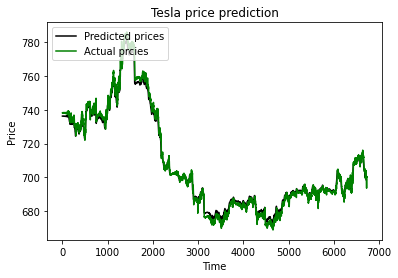

In [11]:
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_prices, color="green", label="Actual prcies")
plt.title(f'Tesla price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [12]:
new_data, new_meta_data = ts.get_intraday(symbol='MSFT', interval = '1min', outputsize = 'full')
new_close_data = new_data['4. close']

new_scaled_data = scaler.fit_transform(new_close_data.values.reshape(-1,1))

x_test = []

prediction_days = 60

for x in range(prediction_days, len(new_scaled_data)):
    x_test.append(new_scaled_data[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)


In [13]:
actual_new_prices = new_data['4. close'].values

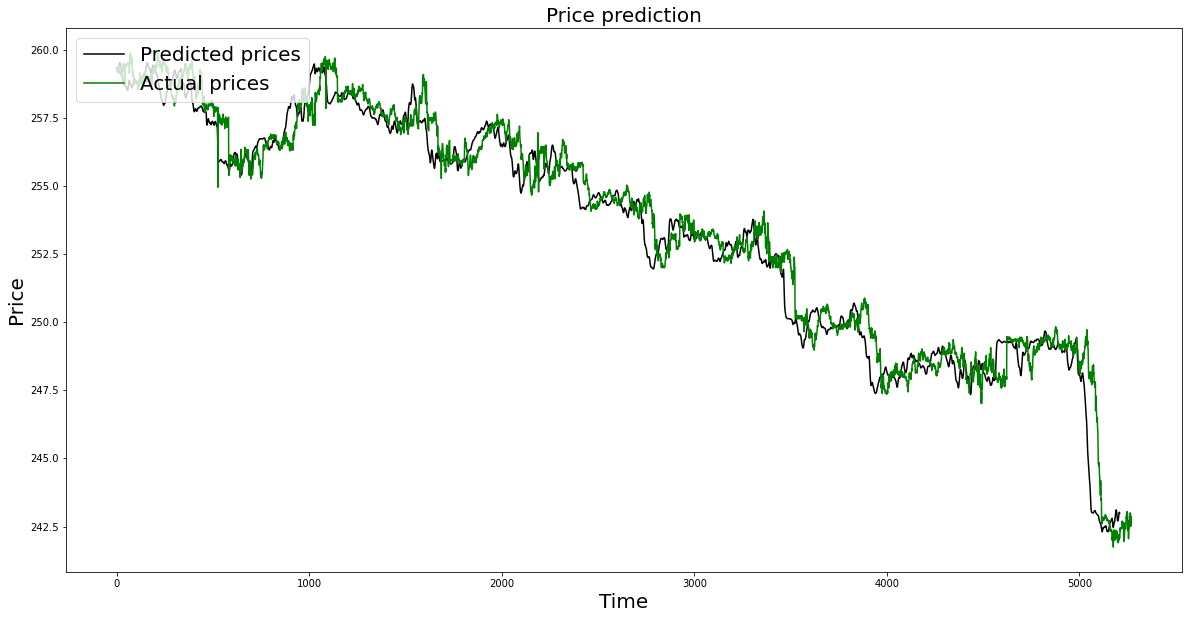

In [14]:
plt.figure(figsize=(20,10))
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_new_prices, color="green", label="Actual prices")
plt.title(f'Price prediction', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()